In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from patsy import dmatrix

pd.options.display.max_columns = 300
pd.options.display.max_rows = 25

# Getting & Selecting Data

In [2]:
df = pd.read_csv('NFL Play by Play 2009-2018.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.to_pickle('nfl_playbyplay.pkl')

In [4]:
nfl_df = pd.read_pickle("nfl_playbyplay.pkl")

In [5]:
nfl_df.play_type.value_counts()

pass           186677
run            132692
no_play         42431
kickoff         25552
punt            23914
extra_point     10934
field_goal       9777
qb_kneel         3830
qb_spike          690
Name: play_type, dtype: int64

In [6]:
# Select only pass and run plays
pass_run_df = df[(nfl_df.play_type == 'pass') | (nfl_df.play_type == 'run')]

In [7]:
pass_run_df.head(5)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [8]:
# Selecting my features
columns = ['play_id', 'game_id', 'posteam_type', 'play_type', 'ydstogo', 'down', 'wp', 'yardline_100', 'half_seconds_remaining', 'score_differential', 'posteam_timeouts_remaining', 'interception', 'fumble']

In [9]:
new_pass_run_df = pass_run_df[columns]

In [10]:
new_pass_run_df.replace([np.inf, -np.inf], np.nan, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [11]:
new_pass_run_df.isna().sum()

play_id                         0
game_id                         0
posteam_type                    0
play_type                       0
ydstogo                         0
down                          678
wp                              2
yardline_100                    0
half_seconds_remaining         17
score_differential              0
posteam_timeouts_remaining      0
interception                    0
fumble                          0
dtype: int64

In [12]:
# Remove 2pt conversions
new_pass_run_df = new_pass_run_df[new_pass_run_df['down'].notnull()]

# Drop rows where win percentage is null
new_pass_run_df = new_pass_run_df[new_pass_run_df['wp'].notnull()]

# Zero-fill rows where half_seconds_remaining is null
new_pass_run_df['half_seconds_remaining'].fillna(0, inplace=True)

In [13]:
# Convert target from categorical to numeric (run=1, pass=0)
new_pass_run_df['run_or_pass'] = new_pass_run_df['play_type'].astype("category").cat.codes

# Add numeric column for home/away team (home=1, away=0)
new_pass_run_df['home_away'] = new_pass_run_df['posteam_type'].astype("category").cat.codes

# Feature Engineering

In [14]:
# Yards per play needed for first down
new_pass_run_df['fd_ydsperplay'] = new_pass_run_df['ydstogo'] / (5 - new_pass_run_df['down'])

In [15]:
# Aggregate fumbles and interceptions by game, by team up to current play
fumbles_ints = new_pass_run_df[['play_id','game_id', 'posteam_type', 'interception', 'fumble']]

cumsum_df = fumbles_ints.groupby(['posteam_type', 'game_id']).agg({'interception': ['cumsum'],
                                                                  'fumble': ['cumsum']})
fumbles_ints = fumbles_ints.join(cumsum_df, how='left')

fumbles_ints.drop(columns =["posteam_type", "interception", "fumble"], inplace=True)

new_pass_run_df = pd.merge(new_pass_run_df, fumbles_ints, on=['play_id', 'game_id'], how='left')

new_pass_run_df.drop(columns =["interception", "fumble"], inplace=True)

new_pass_run_df['interception_cum'] = new_pass_run_df['interception', 'cumsum']
new_pass_run_df['fumble_cum'] = new_pass_run_df['fumble', 'cumsum']

new_pass_run_df.drop(columns =[['interception', 'cumsum'], ['fumble', 'cumsum']], inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [16]:
# Create dummies by playtype
dummies = pd.get_dummies(new_pass_run_df['play_type'])
new_pass_run_df = pd.concat([new_pass_run_df, dummies], axis=1)

In [17]:
pr_df = new_pass_run_df[['play_id','game_id', 'posteam_type', 'run', 'pass']]
pr_cumsum_df = pr_df.groupby(['posteam_type', 'game_id']).agg({'run': ['cumsum'],
                                                                  'pass': ['cumsum']})
pr_df = pr_df.join(pr_cumsum_df, how='left')
pr_df.drop(columns =["posteam_type", "pass", "run"], inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [18]:
new_pass_run_df = pd.merge(new_pass_run_df, pr_df, on=['play_id', 'game_id'], how='left')

In [20]:
new_pass_run_df['cum_runs'] = new_pass_run_df['run', 'cumsum']
new_pass_run_df['cum_pass'] = new_pass_run_df['pass', 'cumsum']

new_pass_run_df.drop(columns =[['run', 'cumsum'], ['pass', 'cumsum']], inplace=True)

In [21]:
new_pass_run_df.drop(columns =['run', 'pass'], inplace=True)

In [22]:
new_pass_run_df['cum_pct_run'] = new_pass_run_df['cum_runs']/(new_pass_run_df['cum_runs'] + new_pass_run_df['cum_pass'])

In [23]:
new_pass_run_df.drop(columns={'play_type', 'posteam_type'}, inplace=True)

# EDA

In [24]:
# Drop play_id and game_id
new_pass_run_df.drop(columns={'play_id', 'game_id'}, inplace=True)

In [25]:
# Assign final model data
model_data = new_pass_run_df.copy()

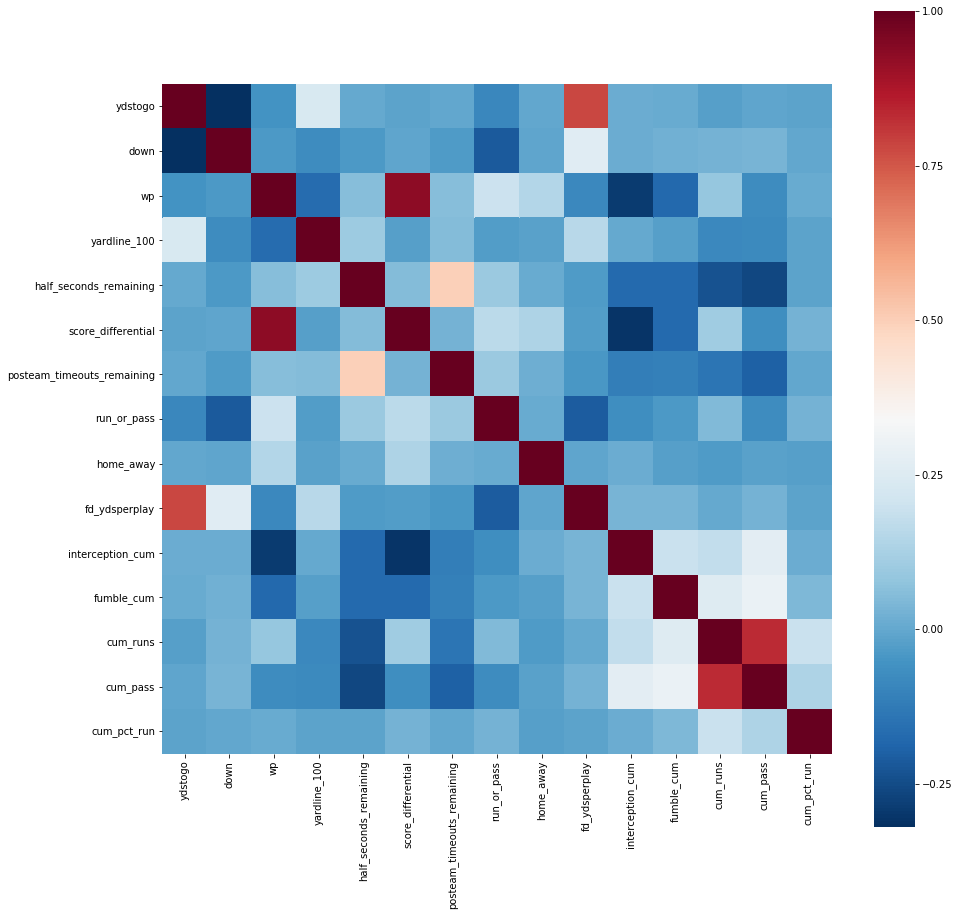

In [28]:
# Plot correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [ ]:
new_pass_run_df[['cum_runs', 'cum_pass']] = new_pass_run_df[['cum_runs', 'cum_pass']].astype('int8')

In [ ]:
new_pass_run_df.info()

In [27]:
new_pass_run_df[np.isfinite(new_pass_run_df) | np.isnan(new_pass_run_df)].shape

(343617, 15)

# Model Setup

In [29]:
model_data.columns

Index(['ydstogo', 'down', 'wp', 'yardline_100', 'half_seconds_remaining',
       'score_differential', 'posteam_timeouts_remaining', 'run_or_pass',
       'home_away', 'fd_ydsperplay', 'interception_cum', 'fumble_cum',
       'cum_runs', 'cum_pass', 'cum_pct_run'],
      dtype='object')

In [31]:
# Setup Patsy dmatrix

# x_cols = ['home_away', 'ydstogo', 'down', 'wp', 'yardline_100',
#            'half_seconds_remaining', 'score_differential',
#            'posteam_timeouts_remaining', 'interception_cum', 'fumble_cum',
#            'fd_ydsperplay', 'cum_runs', 'cum_pass', 'cum_pct_run']

# x_str = x_cols[0]
# for col in x_cols[1:]:
#     x_str = x_str + ' + ' + col

# x_patsy = dmatrix(x_str, model_data)
# x_patsy.shape

(343617, 15)

In [32]:
# Shuffle and split
from sklearn.utils import shuffle

x_raw = x_patsy
y_raw = model_data['run_or_pass']

x_mid, x_test, y_mid, y_test = train_test_split(x_raw, y_raw, \
                                                            test_size=0.2, shuffle=True, stratify=y_raw, random_state=41)
x_train, x_val, y_train, y_val = train_test_split(x_mid, y_mid, \
                                                            test_size=0.25, shuffle=True, stratify=y_mid, random_state=42)

In [33]:
# Normalize variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)

ValueError: Input contains infinity or a value too large for dtype('float64').

# Modeling 💁

### KNN

In [ ]:
ks = [1, 5, 20, 50, 100, 500]
param_grid = dict(n_neighbors=ks)

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(x_norm_train, y_train)

print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(x_norm_train, y_train)))

### Logistic Regression

In [ ]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, label_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, label_test)))

In [ ]:
logit.predict_proba(X_test.values[:5,])

In [ ]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
x    plt.ylabel('actual')

In [ ]:
make_confusion_matrix(logit)